# Scalable GP Classification (w/ KISS-GP)

This example shows how to use a `GridInducingVariationalGP` module. This classification module is designed for when the function you're modeling has 2-3 dimensional inputs and you don't believe that the output can be additively decomposed.

In this example, the function is checkerboard of 1/3x1/3 squares with labels of -1 or 1


 Here we use KISS-GP (https://arxiv.org/pdf/1503.01057.pdf) to classify

In [5]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# We make an nxn grid of training points
# In [0,1]x[0,1] spaced every 1/(n-1)
n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        # True function is checkerboard of 1/3x1/3 squares with labels of -1 or 1
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))

In [7]:
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=10, grid_bounds=[(0, 1), (0, 1)])
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                log_lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    exp(0), exp(3), sigma=0.1, log_transform=True
                )
            )
        )
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = GPClassificationModel()
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [8]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.SGD([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, num_data=len(train_y))

def train():
    num_iter = 200
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()
        
# Get clock time
%time train()

Iter 1/200 - Loss: 77.499
Iter 2/200 - Loss: 52.928
Iter 3/200 - Loss: 54.125
Iter 4/200 - Loss: 54.212
Iter 5/200 - Loss: 54.186
Iter 6/200 - Loss: 54.172
Iter 7/200 - Loss: 54.089
Iter 8/200 - Loss: 54.257
Iter 9/200 - Loss: 54.199
Iter 10/200 - Loss: 54.181
Iter 11/200 - Loss: 54.175
Iter 12/200 - Loss: 54.206
Iter 13/200 - Loss: 54.183
Iter 14/200 - Loss: 54.196
Iter 15/200 - Loss: 54.138
Iter 16/200 - Loss: 54.203
Iter 17/200 - Loss: 54.194
Iter 18/200 - Loss: 54.166
Iter 19/200 - Loss: 54.199
Iter 20/200 - Loss: 54.161
Iter 21/200 - Loss: 54.121
Iter 22/200 - Loss: 54.115
Iter 23/200 - Loss: 54.152
Iter 24/200 - Loss: 54.123
Iter 25/200 - Loss: 54.173
Iter 26/200 - Loss: 54.107
Iter 27/200 - Loss: 54.081
Iter 28/200 - Loss: 54.136
Iter 29/200 - Loss: 54.113
Iter 30/200 - Loss: 54.084
Iter 31/200 - Loss: 54.090
Iter 32/200 - Loss: 54.158
Iter 33/200 - Loss: 54.143
Iter 34/200 - Loss: 54.128
Iter 35/200 - Loss: 54.159
Iter 36/200 - Loss: 54.097
Iter 37/200 - Loss: 54.098
Iter 38/20

(-0.5, 1.5)

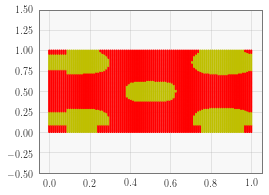

In [13]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize figiure an axis
f, ax = plt.subplots(1, 1, figsize=(4, 3))

n = 100
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)
        
with torch.no_grad(), gpytorch.beta_features.fast_pred_var():
    predictions = likelihood(model(test_x))

# prob<0.5 --> label -1 // prob>0.5 --> label 1
pred_labels = predictions.mean.ge(0.5).float().mul(2).sub(1).numpy()
# Colors = yellow for 1, red for -1
color = []
for i in range(len(pred_labels)):
    if pred_labels[i] == 1:
        color.append('y')
    else:
        color.append('r')
        
# Plot data a scatter plot
ax.scatter(test_x[:, 0], test_x[:, 1], color=color, s=1)
ax.set_ylim([-0.5, 1.5])